# Brusselator Data Analysis Notebook

This notebook provides analysis and visualization for Brusselator simulation data.

In [45]:
# Import required libraries
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from functools import partial
import re
import os
import sys

In [46]:
# Global variable
n_coupled = 2
coupled_idx = 1
n_snapshots = 100
n_params = 5
n_ims = 10

In [47]:
def plot(data):
    global_min = np.min(data)
    global_max = np.max(data)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

    ims = []

    # Display the first snapshot initially; this will be updated in the animation
    matrix = data[0, 0, :, coupled_idx::n_coupled]
    im = ax.imshow(
        matrix, cmap="viridis", aspect="equal", vmin=global_min, vmax=global_max
    )
    ims.append(im)
    ax.set_xlabel("y")
    ax.set_ylabel("x")

    return fig, ax, ims

In [48]:
def animate(snapshot, data, ims, ax):
    matrix = data[0, snapshot, :, coupled_idx::n_coupled]
    im = ims[0]
    im.set_array(matrix)  # Update data for each coupled component
    name = "u" if coupled_idx == 0 else "v"
    ax.set_title(f"Snapshot {snapshot + 1}, {name}")

    return ims

In [49]:
def make_animation(data, name, out_dir):
    fig, ax, ims = plot(data)
    cbar = fig.colorbar(ims[0], ax=ax)
    ani = animation.FuncAnimation(
        fig,
        partial(animate, data=data, ims=ims, ax=ax),
        frames=data.shape[1],
        interval=100,
        blit=True,
    )
    out_name = os.path.join(out_dir, name.replace("_output.nc", ".mp4"))
    ani.save(out_name, writer="ffmpeg", dpi=150)
    plt.close(fig)

In [50]:
def save_final_frame(data, name, out_dir):
    fig, axes, ims = plot(data)
    animate(data.shape[1] - 1, data, ims, axes)
    plt.savefig(
        os.path.join(out_dir, name.replace("_output.nc", "_final.png")), dpi=150
    )
    plt.close()
    return data

In [51]:
def convergence_plot(data, param, out_dir, A, B):
    steady_state = np.zeros_like(data[0, 0, :, :])
    steady_state[:, 0::n_coupled] = A
    steady_state[:, 1::n_coupled] = B / A

    l1 = np.zeros((data.shape[1], 2))

    for i in range(data.shape[1]):
        l1[i, 0] = i
        l1[i, 1] = np.linalg.norm(data[0, i, :, :] - steady_state, ord=1) / np.prod(
            data[0, i, :, :].shape
        )

    plt.plot(l1[:, 0], l1[:, 1], label=f"{param}")
    plt.xlabel("Iteration")
    plt.ylabel("|u - u*| + |v - v*|")
    plt.legend()

In [52]:
# Set up configuration parameters
dir_path = "../data/gs_sp"  # Default data directory
out_dir = "../out"  # Default output directory
anim = True  # Generate animation
save_final = False  # Save final frame
conv = False  # Compute convergence (currently commented out in original script)

In [53]:
# Prepare output directory
dir_name = os.path.basename(dir_path)
out_dir = os.path.join(out_dir, dir_name)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [54]:
# Find NetCDF files
files = []
for file in os.listdir(dir_path):
    if file.endswith("_output.nc"):
        files.append(file)
files

['gs-sparsity_2_output.nc',
 'gs-sparsity_10_output.nc',
 'gs-sparsity_5_output.nc',
 'gs-sparsity_50_output.nc',
 'gs-sparsity_1_output.nc']

In [55]:
# Format file names
files_formatted = []
for f in files:
    fname = os.path.basename(f)
    if fname.startswith("gs-"):
        # extract number
        s = re.findall(r"[-+]?\d*\.\d+|\d+", fname)[0]
        files_formatted.append((f, int(s)))
        
files_formatted.sort(key=lambda x: (x[1]))
files_formatted

[('gs-sparsity_1_output.nc', 1),
 ('gs-sparsity_2_output.nc', 2),
 ('gs-sparsity_5_output.nc', 5),
 ('gs-sparsity_10_output.nc', 10),
 ('gs-sparsity_50_output.nc', 50)]

In [56]:
# Process files
ims = []
for f, _ in files_formatted:
    print(f"Processing {f}")
    d = nc.Dataset(os.path.join(dir_path, f))
    data = d["data"][:]
    if anim:
        make_animation(data, f, out_dir)
    if save_final:
        save_final_frame(data, f, out_dir)
    for i in range(n_ims):
        print(n_snapshots // n_ims * i)
        ims.append(data[0, n_snapshots // n_ims * i, :, coupled_idx::n_coupled])

Processing gs-sparsity_1_output.nc
0
10
20
30
40
50
60
70
80
90
Processing gs-sparsity_2_output.nc
0
10
20
30
40
50
60
70
80
90
Processing gs-sparsity_5_output.nc
0
10
20
30
40
50
60
70
80
90
Processing gs-sparsity_10_output.nc
0
10
20
30
40
50
60
70
80
90
Processing gs-sparsity_50_output.nc
0
10
20
30
40
50
60
70
80
90


Done


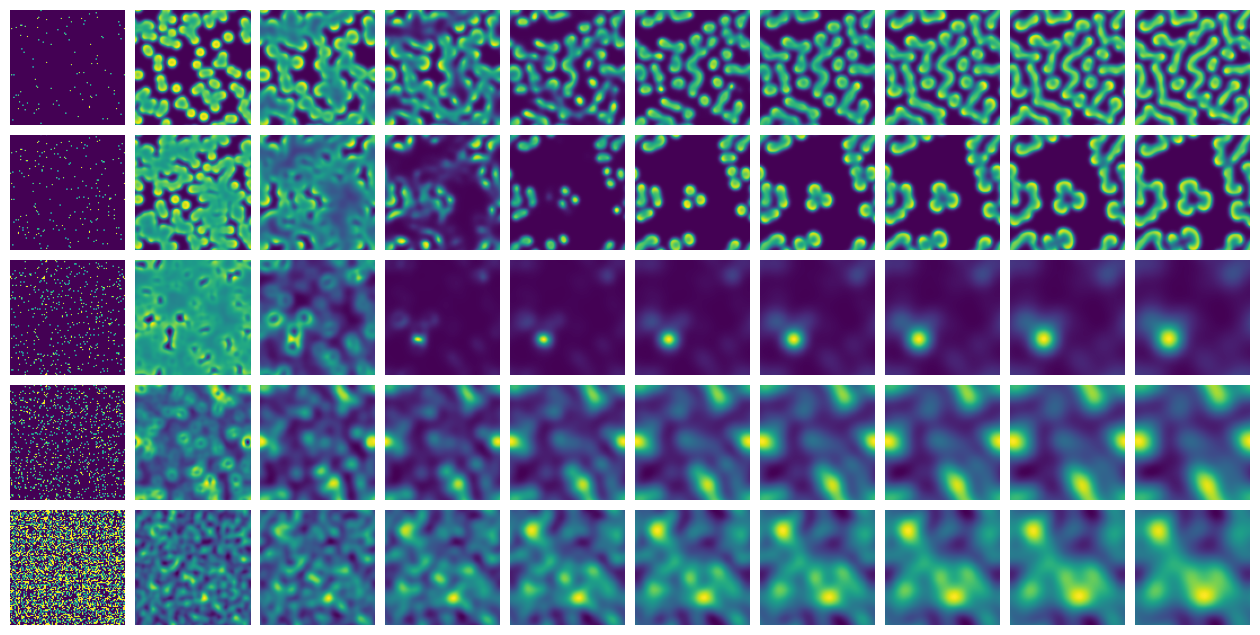

In [57]:
# Create grid of final frames
fig = plt.figure(figsize=(16, 24))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(n_params, n_ims),
    axes_pad=0.1,  # pad between Axes in inch.
)

for i, (ax, im) in enumerate(zip(grid, ims)):
    # ax.set_title(f"sp = {s}")
    ax.axis("off")
    ax.set_aspect("equal")
    ax.imshow(im, cmap="viridis")

plt.savefig(os.path.join(out_dir, "u.png"), dpi=150)
print("Done")